In [7]:
from pandeia.engine.perform_calculation import perform_calculation
from pandeia.engine.calc_utils import build_default_calc
import numpy as np
import stpsf
from stpsf import roman
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from tqdm import tqdm
import os
import pandas as pd

In [8]:
'''
Code adapted from original code by Eddie Schlafly 
'''

filts = ['f062','f087','f106','f129','f158','f184','f213']
wfi = roman.WFI()

# Lancaster+2022
ab_minus_vega = dict(f062=0.147,
                     f087=0.485,
                     f106=0.647,
                     f129=0.950,
                     f146=1.012,
                     f158=1.281,
                     f184=1.546,
                     f213=1.819)

#see here for WFI MultiAccum Table descriptions:
#https://roman-docs.stsci.edu/roman-instruments-home/wfi-imaging-mode-user-guide/observing-with-the-wfi-in-imaging-mode/wfi-multiaccum-tables

allowed_ma_names = ['IM_60_6_S','IM_66_6','IM_76_7_S','IM_85_7','IM_95_7','IM_101_7','IM_107_7','IM_107_8_S','IM_120_8',\
                    'IM_135_8','IM_152_9','IM_171_10','IM_193_11','IM_193_14_S','IM_225_13','IM_250_14','IM_284_14',\
                    'IM_294_16','IM_307_16','IM_360_16','IM_409_16','IM_420_16','IM_460_16','IM_500_16','IM_550_16',\
                    'IM_600_16','IM_650_16','IM_700_16','IM_750_16','IM_800_16','IM_900_16','IM_950_16','IM_1000_16']

allowed_backgrounds = ['hltds','gbtds_mid_5stripe',\
                       'hlwas-medium_field1','hlwas-medium_field2',\
                       'hlwas-wide_field1','hlwas-wide_field2',\
                       'hlwas-wide_field3','hlwas-wide_field4']

# allowed_background_levels = ['high','medium','low']
allowed_background_levels = ['medium']

ma_integration_times = {}
for name in allowed_ma_names:
    ma_integration_times[name] = int(name.split('_')[1])

def get_psf_report(filt,mag,ma_table_name,
                   background,background_level):
    """
    SNR from Pandeia.  Lots of stuff in the "report."
    Supposed to give the SNR in a 0.2" aperture for a point source
    given a particular background level.
    """
    calc = build_default_calc('roman', 'wfi', 'imaging')
    # default source is a point source
    calc['scene'][0]['spectrum']['normalization']['norm_flux'] = mag
    calc['scene'][0]['spectrum']['normalization']['norm_fluxunit'] = 'abmag'
    calc['configuration']['detector']['nexp'] = 1
    calc['configuration']['instrument']['filter'] = filt
    calc['configuration']['detector']['ma_table_name'] = ma_table_name
    calc['strategy']['background_subtraction'] = False
    calc['background'] = background
    calc['background_level'] = background_level
    report = perform_calculation(calc)
    return report


def snr_vs_mag(filt, mag, ma_table_name, 
               background = 'hlwas-wide_field1',
               background_level = 'medium'):
    return np.array([get_psf_report(filt, 
                                    mag0, 
                                    ma_table_name, 
                                    background, 
                                    background_level)['scalar']['sn'] for mag0 in mag])


In [3]:

def pos_err_plots(ma_table_name,
          filts=filts,
          errfloor = 0.01,
          vega=False,
          factors = None,
          mag = np.linspace(16, 29, 21, endpoint=True), 
          background = 'hlwas-wide_field1',
          background_level = 'medium',
          show_plots = True):
    if type(factors) == type(None):
        factors = np.ones(len(filts))
        
    if show_plots:
        plt.figure(figsize=(8,10))
        plt.clf()

    outdata = {}
    for filt_ind,filt in enumerate(filts):
        wfi.filter = filt.upper()

        magplot = mag.copy()
        if vega:
            magplot -= ab_minus_vega[filt]
        snr = snr_vs_mag(filt, mag, ma_table_name, 
                        background=background, 
                        background_level=background_level)
        
        asterr = (wfi.pixelscale*1000) / snr * factors[filt_ind]
        outdata[filt] = {
            'mags':mag,
            'magplot':magplot,
            'vega':vega,
            'pos_errs':asterr,
            'snrs':snr,
        }
        
        if show_plots:
            plt.subplot(3, 1, 1)
            plt.plot(magplot, snr, label=filt.upper())
            plt.subplot(3, 1, 2)
            plt.plot(magplot, asterr, label=filt.upper())
                
    if show_plots:
        ax = plt.subplot(3, 1, 1)
        plt.ylim(0.1, 1000)
        plt.yscale('log')
        plt.ylabel('S/N')
        leg = plt.legend(loc='best')
        for line in leg.get_lines():
            line.set_linewidth(5.0)
        plt.grid()
        plt.gca().xaxis.set_ticklabels([])

        ax = plt.subplot(3, 1, 2)
        if not vega:
            plt.xlabel('AB mag')
        else:
            plt.xlabel('Vega mag')
        plt.ylim(0.1, 1000)
        plt.axhline(errfloor*(wfi.pixelscale*1000),c='r',ls='--',lw=1)
        plt.ylabel('Position Uncertainty (mas)')
        plt.yscale('log')
        plt.grid()
    
        plt.subplots_adjust(hspace=0.1)
        plt.show()
        plt.close('all')

    return outdata


In [4]:
'''
Read in a corresponding filter's PSF to measure the position uncertainty.
Specifically, learn the relationship between the flux uncertainty (i.e. S/N)
and the uncertainty in X,Y position. I find that this is a single number that
does not change as a function of flux, so we only need to learn one number
per filter that captures the position uncertainty as a function of S/N or mag.
'''

np.random.seed(101)


n_repeat = 1 #can repeat the data draws to explore statistics, but average final results are the same as 1 draw
n_subpixel = 5 #number of subpixels for super sampling the PSF
dmu = 0.0001 #for numerical dervatives of x and y positions
n_mask = 50 #number of pixels to mask at edges of data (i.e. only look at core)
true_dx,true_dy = 0.,0. #keep set to 0 for these tests
fluxes = np.logspace(-1,6,8)[::-1] #fluxes to test (above background)

all_filt_data = {}

for filt in wfi.filter_list:
    filt = str(filt)
    print(filt)
    
    wfi = roman.WFI()
    wfi.filter = filt
    pixscale = wfi.pixelscale
    
    wfipsf = wfi.calc_psf(fov_pixels=201,oversample=n_subpixel)
    wfipsf[1].data[:n_mask] = np.nan
    wfipsf[1].data[-n_mask:] = np.nan
    wfipsf[1].data[:,:n_mask] = np.nan
    wfipsf[1].data[:,-n_mask:] = np.nan

    subpix_edges = np.linspace(-0.5,0.5,n_subpixel+1)
    subpix_centers = 0.5*(subpix_edges[1:]+subpix_edges[:-1])
    x_coords = (np.arange(wfipsf[1].data.shape[0])-wfipsf[1].data.shape[0]//2)
    
    sub_x = np.sort(np.ravel(x_coords[:,None]+subpix_centers))
    
    sub_xx,sub_yy = np.meshgrid(sub_x,sub_x)
    sub_xy = np.zeros((*sub_xx.shape,2))
    sub_xy[:,:,0] = sub_xx
    sub_xy[:,:,1] = sub_yy
    
    model = wfipsf[0].data
    interpolator = RegularGridInterpolator((sub_x,sub_x),model,bounds_error=False,fill_value=None)
    
    all_snrs = np.zeros((n_repeat,len(fluxes)))
    all_param_errs = np.zeros((n_repeat,len(fluxes),3))
    all_sigmas = np.zeros((n_repeat,len(fluxes)))
    all_true_params = np.zeros((n_repeat,len(fluxes),3))
    
    for r_ind,_ in enumerate(tqdm(np.arange(n_repeat),total=n_repeat)):
        
        flux_snrs = np.zeros_like(fluxes)
        flux_param_errs = np.zeros((len(fluxes),3))
        flux_sigmas = np.zeros((len(fluxes)))
        
        dx,dy = true_dx,true_dy
        
        for flux_ind,flux in enumerate(fluxes):    
            truth = np.array([true_dx,true_dy,flux])
        
            data_1d = np.ravel(wfipsf[1].data)*flux
            errs_1d = np.sqrt(data_1d)
            # data_1d = np.random.poisson(data_1d)
            data_1d += np.random.randn(len(data_1d))*errs_1d
            bad_data = ~np.isfinite(data_1d)
            data_1d[bad_data] = 0
            ivars_1d = np.power(errs_1d,-2)
            ivars_1d[bad_data] = 0
            
            new_model = interpolator(sub_xy-np.array([dx,dy]))
            new_model_px = interpolator(sub_xy-np.array([dx+dmu,dy]))
            new_model_mx = interpolator(sub_xy-np.array([dx-dmu,dy]))
            new_model_py = interpolator(sub_xy-np.array([dx,dy+dmu]))
            new_model_my = interpolator(sub_xy-np.array([dx,dy-dmu]))
            
            temp_model = np.copy(new_model[::n_subpixel])
            temp_model_px = np.copy(new_model_px[::n_subpixel])
            temp_model_mx = np.copy(new_model_mx[::n_subpixel])
            temp_model_py = np.copy(new_model_py[::n_subpixel])
            temp_model_my = np.copy(new_model_my[::n_subpixel])
            for j in range(1,n_subpixel):
                temp_model += new_model[j::n_subpixel]
                temp_model_px += new_model_px[j::n_subpixel]
                temp_model_mx += new_model_mx[j::n_subpixel]
                temp_model_py += new_model_py[j::n_subpixel]
                temp_model_my += new_model_my[j::n_subpixel]
            out_model = np.copy(temp_model[:,::n_subpixel])
            out_model_px = np.copy(temp_model_px[:,::n_subpixel])
            out_model_mx = np.copy(temp_model_mx[:,::n_subpixel])
            out_model_py = np.copy(temp_model_py[:,::n_subpixel])
            out_model_my = np.copy(temp_model_my[:,::n_subpixel])
            for j in range(1,n_subpixel):
                out_model += temp_model[:,j::n_subpixel]
                out_model_px += temp_model_px[:,j::n_subpixel]
                out_model_mx += temp_model_mx[:,j::n_subpixel]
                out_model_py += temp_model_py[:,j::n_subpixel]
                out_model_my += temp_model_my[:,j::n_subpixel]
            
            dm_dx = (out_model_px-out_model_mx)/(2*dmu)
            dm_dy = (out_model_py-out_model_my)/(2*dmu)
            
            
            deriv_mat = np.zeros((dm_dx.size,3))
            deriv_mat[:,0] = np.ravel(dm_dx.T*flux)
            deriv_mat[:,1] = np.ravel(dm_dy.T*flux)
            deriv_mat[:,2] = np.ravel(out_model.T)
            
            V_inv_dot_design = deriv_mat*ivars_1d[:,None]
            V_inv = np.einsum('ji,jk->ik',deriv_mat,V_inv_dot_design)
            V = np.linalg.inv(V_inv)
            change_vect = np.linalg.solve(V_inv,np.einsum('ji,j->i',V_inv_dot_design,(data_1d-np.ravel(out_model.T*flux))))
            
            curr_params = np.array([dx,dy,flux])
            new_params = curr_params+change_vect
        
            flux_snrs[flux_ind] = flux/np.sqrt((V[2,2]))
            flux_param_errs[flux_ind] = np.sqrt(np.diag(V))
            flux_sigmas[flux_ind] = np.sqrt(np.dot(np.dot(new_params-truth,V_inv),new_params-truth))
    
            all_true_params[r_ind,flux_ind] = truth
    
        all_snrs[r_ind] = flux_snrs
        all_param_errs[r_ind] = flux_param_errs
        all_sigmas[r_ind] = flux_sigmas
            
    all_filt_data[filt] = {
        'snrs':all_snrs,
        'fluxes':fluxes,
        'param_errs':all_param_errs,
        'sigmas':all_sigmas,
        'true_params':all_true_params,
        'snr_to_pos_err_mult':np.median((np.mean(all_param_errs[:,:,:2],axis=-1)*all_snrs)),
    }



F062


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


F087


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


F106


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


F129


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


F146


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


F158


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


F184


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


PRISM


Attempted to get aberrations at wavelength 1.8e-06 outside the range of the reference data; clipping to closest wavelength 1.8e-06
Attempted to get aberrations at wavelength 1.8e-06 outside the range of the reference data; clipping to closest wavelength 1.8e-06
Attempted to get aberrations at wavelength 1.8e-06 outside the range of the reference data; clipping to closest wavelength 1.8e-06
Attempted to get aberrations at wavelength 1.8e-06 outside the range of the reference data; clipping to closest wavelength 1.8e-06
Attempted to get aberrations at wavelength 1.8e-06 outside the range of the reference data; clipping to closest wavelength 1.8e-06
100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


F213


Attempted to get aberrations at wavelength 2.3e-06 outside the range of the reference data; clipping to closest wavelength 2.3e-06
Attempted to get aberrations at wavelength 2.3e-06 outside the range of the reference data; clipping to closest wavelength 2.3e-06
Attempted to get aberrations at wavelength 2.3e-06 outside the range of the reference data; clipping to closest wavelength 2.3e-06
Attempted to get aberrations at wavelength 2.3e-06 outside the range of the reference data; clipping to closest wavelength 2.3e-06
Attempted to get aberrations at wavelength 2.3e-06 outside the range of the reference data; clipping to closest wavelength 2.3e-06
100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


GRISM0


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


GRISM1


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


F062 0.857576174976513
F087 0.7628549059160477
F106 0.7086581803932848
F129 0.7132944819128739
F146 0.7915048391248019
F158 0.7560548240757055
F184 0.7836270808020873
F213 0.8727262053036416


/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/detector.py:915: RuntimeWarning: invalid value encountered in divide
  k_i = (f_0 * tmean - f_1) * w_ij / d
/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/report.py:781: RuntimeWarning: divide by zero encountered in scalar divide
  self.r['scalar']['sn'] = signal/noise
/var/folders/xs/flwfyss51t7d8vd8jhqz00xh0000gn/T/ipykernel_30780/4114471953.py:28: RuntimeWarning: divide by zero encountered in divide
  asterr = (wfi.pixelscale*1000) / snr * factors[filt_ind]
/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/detector.py:915: RuntimeWarning: invalid value encountered in divide
  k_i = (f_0 * tmean - f_1) * w_ij / d
/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/report.py:781: RuntimeWarning: divide by zero encountered in scalar divide
  self.r['scalar']['sn'] = signal/noise
/var/folders/xs/flwfyss51t7d8vd8jhqz00xh0000gn/T/ipykernel_3078

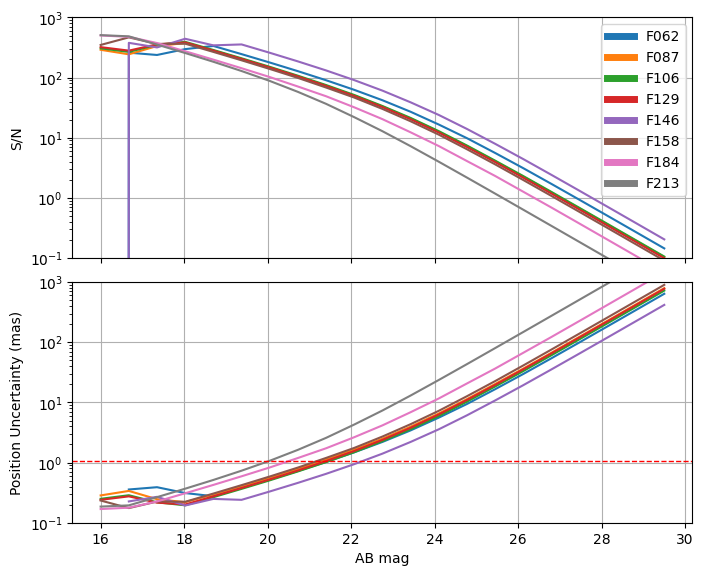

In [5]:
'''
There is a single factor that allows you to go from S/N of the flux
to the uncertainty in position, that is pos_uncert = 1/(S/N)*factor
'''

good_filt_list = []
good_filt_snr_to_pos_err_factors = []
for filt in wfi.filter_list:
    filt = str(filt)
    if not filt.startswith('F'):
        continue
    print(filt,all_filt_data[filt]['snr_to_pos_err_mult'])
    good_filt_list.append(filt.lower())
    good_filt_snr_to_pos_err_factors.append(all_filt_data[filt]['snr_to_pos_err_mult'])

ma_table_name = 'IM_107_7'
plotdata = pos_err_plots(ma_table_name = ma_table_name,
                         filts = good_filt_list,
                         errfloor = 0.01,
                         vega = False,
                         factors = good_filt_snr_to_pos_err_factors,
                         mag = np.linspace(16, 29.5, 21, endpoint=True), 
                         background = 'hlwas-wide_field1',
                         background_level = 'medium',
                         show_plots = True)


In [9]:
datapath = './data/'
if not os.path.isdir(datapath):
    os.mkdir(datapath)

overwrite = False

for background in allowed_backgrounds:
    for background_level in allowed_background_levels:
        background_string = f'{background}_{background_level}'
        for ma_table_name in allowed_ma_names:    
            print(ma_table_name,background_string)
            
            first = True
            bad_data = False 
            for filt in good_filt_list:
                out_fname = f'{datapath}roman_{ma_table_name}_{background_string}_{filt.upper()}_pos_errs.csv'
                if (os.path.isfile(out_fname)) and (not overwrite):
                    continue

                #then need to do the slow calculation (for the first time)
                if first:
                    first = False
                    try:
                        curr_plotdata = pos_err_plots(ma_table_name,
                                                    filts = good_filt_list,
                                                    errfloor = 0.01,
                                                    vega = False,
                                                    factors = good_filt_snr_to_pos_err_factors,
                                                    mag = np.arange(16, 27+0.2, 0.2),
                                                    background = background,
                                                    background_level = background_level,
                                                    show_plots = False)
                    except:
                        print(f'SKIPPING: {out_fname} because measuring position uncertainty failed.')
                        plt.close('all')
                        break
                new_data = { 
                    'mags_ab':curr_plotdata[filt]['mags'],
                    'pos_errs_mas':curr_plotdata[filt]['pos_errs'],
                }
                pd.DataFrame(new_data).to_csv(out_fname,index=False)
                # print(ma_table_name,background_string,filt.upper(),out_fname)
            # print()
    # print()


IM_60_6_S hltds_medium
IM_66_6 hltds_medium


/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/detector.py:915: RuntimeWarning: invalid value encountered in divide
  k_i = (f_0 * tmean - f_1) * w_ij / d
/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/report.py:781: RuntimeWarning: divide by zero encountered in scalar divide
  self.r['scalar']['sn'] = signal/noise
/var/folders/xs/flwfyss51t7d8vd8jhqz00xh0000gn/T/ipykernel_30780/4114471953.py:28: RuntimeWarning: divide by zero encountered in divide
  asterr = (wfi.pixelscale*1000) / snr * factors[filt_ind]
/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/detector.py:915: RuntimeWarning: invalid value encountered in divide
  k_i = (f_0 * tmean - f_1) * w_ij / d
/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/report.py:781: RuntimeWarning: divide by zero encountered in scalar divide
  self.r['scalar']['sn'] = signal/noise
/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pand

IM_76_7_S hltds_medium
IM_85_7 hltds_medium
IM_95_7 hltds_medium
IM_101_7 hltds_medium
IM_107_7 hltds_medium
IM_107_8_S hltds_medium
IM_120_8 hltds_medium
IM_135_8 hltds_medium
IM_152_9 hltds_medium
IM_171_10 hltds_medium
IM_193_11 hltds_medium
IM_193_14_S hltds_medium
IM_225_13 hltds_medium
IM_250_14 hltds_medium
IM_284_14 hltds_medium
IM_294_16 hltds_medium
IM_307_16 hltds_medium
IM_360_16 hltds_medium
IM_409_16 hltds_medium
IM_420_16 hltds_medium
IM_460_16 hltds_medium
IM_500_16 hltds_medium
IM_550_16 hltds_medium
IM_600_16 hltds_medium
IM_650_16 hltds_medium
IM_700_16 hltds_medium
IM_750_16 hltds_medium
IM_800_16 hltds_medium
IM_900_16 hltds_medium
IM_950_16 hltds_medium
IM_1000_16 hltds_medium
IM_60_6_S gbtds_mid_5stripe_medium
IM_66_6 gbtds_mid_5stripe_medium


/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/detector.py:915: RuntimeWarning: invalid value encountered in divide
  k_i = (f_0 * tmean - f_1) * w_ij / d
/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/report.py:781: RuntimeWarning: divide by zero encountered in scalar divide
  self.r['scalar']['sn'] = signal/noise
/var/folders/xs/flwfyss51t7d8vd8jhqz00xh0000gn/T/ipykernel_30780/4114471953.py:28: RuntimeWarning: divide by zero encountered in divide
  asterr = (wfi.pixelscale*1000) / snr * factors[filt_ind]
/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/detector.py:915: RuntimeWarning: invalid value encountered in divide
  k_i = (f_0 * tmean - f_1) * w_ij / d
/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/report.py:781: RuntimeWarning: divide by zero encountered in scalar divide
  self.r['scalar']['sn'] = signal/noise
/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pand

IM_76_7_S gbtds_mid_5stripe_medium
IM_85_7 gbtds_mid_5stripe_medium
IM_95_7 gbtds_mid_5stripe_medium
IM_101_7 gbtds_mid_5stripe_medium
IM_107_7 gbtds_mid_5stripe_medium
IM_107_8_S gbtds_mid_5stripe_medium
IM_120_8 gbtds_mid_5stripe_medium
IM_135_8 gbtds_mid_5stripe_medium
IM_152_9 gbtds_mid_5stripe_medium
IM_171_10 gbtds_mid_5stripe_medium
IM_193_11 gbtds_mid_5stripe_medium
IM_193_14_S gbtds_mid_5stripe_medium
IM_225_13 gbtds_mid_5stripe_medium
IM_250_14 gbtds_mid_5stripe_medium
IM_284_14 gbtds_mid_5stripe_medium
IM_294_16 gbtds_mid_5stripe_medium
IM_307_16 gbtds_mid_5stripe_medium
IM_360_16 gbtds_mid_5stripe_medium
IM_409_16 gbtds_mid_5stripe_medium
IM_420_16 gbtds_mid_5stripe_medium
IM_460_16 gbtds_mid_5stripe_medium
IM_500_16 gbtds_mid_5stripe_medium
IM_550_16 gbtds_mid_5stripe_medium
IM_600_16 gbtds_mid_5stripe_medium
IM_650_16 gbtds_mid_5stripe_medium
IM_700_16 gbtds_mid_5stripe_medium
IM_750_16 gbtds_mid_5stripe_medium
IM_800_16 gbtds_mid_5stripe_medium
IM_900_16 gbtds_mid_5strip

/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/detector.py:915: RuntimeWarning: invalid value encountered in divide
  k_i = (f_0 * tmean - f_1) * w_ij / d
/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/report.py:781: RuntimeWarning: divide by zero encountered in scalar divide
  self.r['scalar']['sn'] = signal/noise
/var/folders/xs/flwfyss51t7d8vd8jhqz00xh0000gn/T/ipykernel_30780/4114471953.py:28: RuntimeWarning: divide by zero encountered in divide
  asterr = (wfi.pixelscale*1000) / snr * factors[filt_ind]
/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/detector.py:915: RuntimeWarning: invalid value encountered in divide
  k_i = (f_0 * tmean - f_1) * w_ij / d
/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/report.py:781: RuntimeWarning: divide by zero encountered in scalar divide
  self.r['scalar']['sn'] = signal/noise
/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pand

IM_76_7_S hlwas-medium_field1_medium
IM_85_7 hlwas-medium_field1_medium
IM_95_7 hlwas-medium_field1_medium
IM_101_7 hlwas-medium_field1_medium
IM_107_7 hlwas-medium_field1_medium
IM_107_8_S hlwas-medium_field1_medium
IM_120_8 hlwas-medium_field1_medium
IM_135_8 hlwas-medium_field1_medium
IM_152_9 hlwas-medium_field1_medium
IM_171_10 hlwas-medium_field1_medium
IM_193_11 hlwas-medium_field1_medium
IM_193_14_S hlwas-medium_field1_medium
IM_225_13 hlwas-medium_field1_medium
IM_250_14 hlwas-medium_field1_medium
IM_284_14 hlwas-medium_field1_medium
IM_294_16 hlwas-medium_field1_medium
IM_307_16 hlwas-medium_field1_medium
IM_360_16 hlwas-medium_field1_medium
IM_409_16 hlwas-medium_field1_medium
IM_420_16 hlwas-medium_field1_medium
IM_460_16 hlwas-medium_field1_medium
IM_500_16 hlwas-medium_field1_medium
IM_550_16 hlwas-medium_field1_medium
IM_600_16 hlwas-medium_field1_medium
IM_650_16 hlwas-medium_field1_medium
IM_700_16 hlwas-medium_field1_medium
IM_750_16 hlwas-medium_field1_medium
IM_800_

/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/detector.py:915: RuntimeWarning: invalid value encountered in divide
  k_i = (f_0 * tmean - f_1) * w_ij / d
/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/report.py:781: RuntimeWarning: divide by zero encountered in scalar divide
  self.r['scalar']['sn'] = signal/noise
/var/folders/xs/flwfyss51t7d8vd8jhqz00xh0000gn/T/ipykernel_30780/4114471953.py:28: RuntimeWarning: divide by zero encountered in divide
  asterr = (wfi.pixelscale*1000) / snr * factors[filt_ind]
/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/detector.py:915: RuntimeWarning: invalid value encountered in divide
  k_i = (f_0 * tmean - f_1) * w_ij / d
/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/report.py:781: RuntimeWarning: divide by zero encountered in scalar divide
  self.r['scalar']['sn'] = signal/noise
/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pand

IM_76_7_S hlwas-medium_field2_medium
IM_85_7 hlwas-medium_field2_medium
IM_95_7 hlwas-medium_field2_medium
IM_101_7 hlwas-medium_field2_medium
IM_107_7 hlwas-medium_field2_medium
IM_107_8_S hlwas-medium_field2_medium
IM_120_8 hlwas-medium_field2_medium
IM_135_8 hlwas-medium_field2_medium
IM_152_9 hlwas-medium_field2_medium
IM_171_10 hlwas-medium_field2_medium
IM_193_11 hlwas-medium_field2_medium
IM_193_14_S hlwas-medium_field2_medium
IM_225_13 hlwas-medium_field2_medium
IM_250_14 hlwas-medium_field2_medium
IM_284_14 hlwas-medium_field2_medium
IM_294_16 hlwas-medium_field2_medium
IM_307_16 hlwas-medium_field2_medium
IM_360_16 hlwas-medium_field2_medium
IM_409_16 hlwas-medium_field2_medium
IM_420_16 hlwas-medium_field2_medium
IM_460_16 hlwas-medium_field2_medium
IM_500_16 hlwas-medium_field2_medium
IM_550_16 hlwas-medium_field2_medium
IM_600_16 hlwas-medium_field2_medium
IM_650_16 hlwas-medium_field2_medium
IM_700_16 hlwas-medium_field2_medium
IM_750_16 hlwas-medium_field2_medium
IM_800_

/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/detector.py:915: RuntimeWarning: invalid value encountered in divide
  k_i = (f_0 * tmean - f_1) * w_ij / d
/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/report.py:781: RuntimeWarning: divide by zero encountered in scalar divide
  self.r['scalar']['sn'] = signal/noise
/var/folders/xs/flwfyss51t7d8vd8jhqz00xh0000gn/T/ipykernel_30780/4114471953.py:28: RuntimeWarning: divide by zero encountered in divide
  asterr = (wfi.pixelscale*1000) / snr * factors[filt_ind]
/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/detector.py:915: RuntimeWarning: invalid value encountered in divide
  k_i = (f_0 * tmean - f_1) * w_ij / d
/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/report.py:781: RuntimeWarning: divide by zero encountered in scalar divide
  self.r['scalar']['sn'] = signal/noise
/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pand

IM_76_7_S hlwas-wide_field1_medium
IM_85_7 hlwas-wide_field1_medium
IM_95_7 hlwas-wide_field1_medium
IM_101_7 hlwas-wide_field1_medium
IM_107_7 hlwas-wide_field1_medium
IM_107_8_S hlwas-wide_field1_medium
IM_120_8 hlwas-wide_field1_medium
IM_135_8 hlwas-wide_field1_medium
IM_152_9 hlwas-wide_field1_medium
IM_171_10 hlwas-wide_field1_medium
IM_193_11 hlwas-wide_field1_medium
IM_193_14_S hlwas-wide_field1_medium
IM_225_13 hlwas-wide_field1_medium
IM_250_14 hlwas-wide_field1_medium
IM_284_14 hlwas-wide_field1_medium
IM_294_16 hlwas-wide_field1_medium
IM_307_16 hlwas-wide_field1_medium
IM_360_16 hlwas-wide_field1_medium
IM_409_16 hlwas-wide_field1_medium
IM_420_16 hlwas-wide_field1_medium
IM_460_16 hlwas-wide_field1_medium
IM_500_16 hlwas-wide_field1_medium
IM_550_16 hlwas-wide_field1_medium
IM_600_16 hlwas-wide_field1_medium
IM_650_16 hlwas-wide_field1_medium
IM_700_16 hlwas-wide_field1_medium
IM_750_16 hlwas-wide_field1_medium
IM_800_16 hlwas-wide_field1_medium
IM_900_16 hlwas-wide_field

/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/detector.py:915: RuntimeWarning: invalid value encountered in divide
  k_i = (f_0 * tmean - f_1) * w_ij / d
/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/report.py:781: RuntimeWarning: divide by zero encountered in scalar divide
  self.r['scalar']['sn'] = signal/noise
/var/folders/xs/flwfyss51t7d8vd8jhqz00xh0000gn/T/ipykernel_30780/4114471953.py:28: RuntimeWarning: divide by zero encountered in divide
  asterr = (wfi.pixelscale*1000) / snr * factors[filt_ind]
/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/detector.py:915: RuntimeWarning: invalid value encountered in divide
  k_i = (f_0 * tmean - f_1) * w_ij / d
/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/report.py:781: RuntimeWarning: divide by zero encountered in scalar divide
  self.r['scalar']['sn'] = signal/noise
/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pand

IM_76_7_S hlwas-wide_field2_medium
IM_85_7 hlwas-wide_field2_medium
IM_95_7 hlwas-wide_field2_medium
IM_101_7 hlwas-wide_field2_medium
IM_107_7 hlwas-wide_field2_medium
IM_107_8_S hlwas-wide_field2_medium
IM_120_8 hlwas-wide_field2_medium
IM_135_8 hlwas-wide_field2_medium
IM_152_9 hlwas-wide_field2_medium
IM_171_10 hlwas-wide_field2_medium
IM_193_11 hlwas-wide_field2_medium
IM_193_14_S hlwas-wide_field2_medium
IM_225_13 hlwas-wide_field2_medium
IM_250_14 hlwas-wide_field2_medium
IM_284_14 hlwas-wide_field2_medium
IM_294_16 hlwas-wide_field2_medium
IM_307_16 hlwas-wide_field2_medium
IM_360_16 hlwas-wide_field2_medium
IM_409_16 hlwas-wide_field2_medium
IM_420_16 hlwas-wide_field2_medium
IM_460_16 hlwas-wide_field2_medium
IM_500_16 hlwas-wide_field2_medium
IM_550_16 hlwas-wide_field2_medium
IM_600_16 hlwas-wide_field2_medium
IM_650_16 hlwas-wide_field2_medium
IM_700_16 hlwas-wide_field2_medium
IM_750_16 hlwas-wide_field2_medium
IM_800_16 hlwas-wide_field2_medium
IM_900_16 hlwas-wide_field

/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/detector.py:915: RuntimeWarning: invalid value encountered in divide
  k_i = (f_0 * tmean - f_1) * w_ij / d
/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/report.py:781: RuntimeWarning: divide by zero encountered in scalar divide
  self.r['scalar']['sn'] = signal/noise
/var/folders/xs/flwfyss51t7d8vd8jhqz00xh0000gn/T/ipykernel_30780/4114471953.py:28: RuntimeWarning: divide by zero encountered in divide
  asterr = (wfi.pixelscale*1000) / snr * factors[filt_ind]
/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/detector.py:915: RuntimeWarning: invalid value encountered in divide
  k_i = (f_0 * tmean - f_1) * w_ij / d
/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/report.py:781: RuntimeWarning: divide by zero encountered in scalar divide
  self.r['scalar']['sn'] = signal/noise
/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pand

IM_76_7_S hlwas-wide_field3_medium
IM_85_7 hlwas-wide_field3_medium
IM_95_7 hlwas-wide_field3_medium
IM_101_7 hlwas-wide_field3_medium
IM_107_7 hlwas-wide_field3_medium
IM_107_8_S hlwas-wide_field3_medium
IM_120_8 hlwas-wide_field3_medium
IM_135_8 hlwas-wide_field3_medium
IM_152_9 hlwas-wide_field3_medium
IM_171_10 hlwas-wide_field3_medium
IM_193_11 hlwas-wide_field3_medium
IM_193_14_S hlwas-wide_field3_medium
IM_225_13 hlwas-wide_field3_medium
IM_250_14 hlwas-wide_field3_medium
IM_284_14 hlwas-wide_field3_medium
IM_294_16 hlwas-wide_field3_medium
IM_307_16 hlwas-wide_field3_medium
IM_360_16 hlwas-wide_field3_medium
IM_409_16 hlwas-wide_field3_medium
IM_420_16 hlwas-wide_field3_medium
IM_460_16 hlwas-wide_field3_medium
IM_500_16 hlwas-wide_field3_medium
IM_550_16 hlwas-wide_field3_medium
IM_600_16 hlwas-wide_field3_medium
IM_650_16 hlwas-wide_field3_medium
IM_700_16 hlwas-wide_field3_medium
IM_750_16 hlwas-wide_field3_medium
IM_800_16 hlwas-wide_field3_medium
IM_900_16 hlwas-wide_field

/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/detector.py:915: RuntimeWarning: invalid value encountered in divide
  k_i = (f_0 * tmean - f_1) * w_ij / d
/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/report.py:781: RuntimeWarning: divide by zero encountered in scalar divide
  self.r['scalar']['sn'] = signal/noise
/var/folders/xs/flwfyss51t7d8vd8jhqz00xh0000gn/T/ipykernel_30780/4114471953.py:28: RuntimeWarning: divide by zero encountered in divide
  asterr = (wfi.pixelscale*1000) / snr * factors[filt_ind]
/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/detector.py:915: RuntimeWarning: invalid value encountered in divide
  k_i = (f_0 * tmean - f_1) * w_ij / d
/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/report.py:781: RuntimeWarning: divide by zero encountered in scalar divide
  self.r['scalar']['sn'] = signal/noise
/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pand

IM_76_7_S hlwas-wide_field4_medium
IM_85_7 hlwas-wide_field4_medium
IM_95_7 hlwas-wide_field4_medium
IM_101_7 hlwas-wide_field4_medium
IM_107_7 hlwas-wide_field4_medium
IM_107_8_S hlwas-wide_field4_medium
IM_120_8 hlwas-wide_field4_medium
IM_135_8 hlwas-wide_field4_medium
IM_152_9 hlwas-wide_field4_medium
IM_171_10 hlwas-wide_field4_medium
IM_193_11 hlwas-wide_field4_medium
IM_193_14_S hlwas-wide_field4_medium
IM_225_13 hlwas-wide_field4_medium
IM_250_14 hlwas-wide_field4_medium
IM_284_14 hlwas-wide_field4_medium
IM_294_16 hlwas-wide_field4_medium
IM_307_16 hlwas-wide_field4_medium
IM_360_16 hlwas-wide_field4_medium
IM_409_16 hlwas-wide_field4_medium
IM_420_16 hlwas-wide_field4_medium
IM_460_16 hlwas-wide_field4_medium
IM_500_16 hlwas-wide_field4_medium
IM_550_16 hlwas-wide_field4_medium
IM_600_16 hlwas-wide_field4_medium
IM_650_16 hlwas-wide_field4_medium
IM_700_16 hlwas-wide_field4_medium
IM_750_16 hlwas-wide_field4_medium
IM_800_16 hlwas-wide_field4_medium
IM_900_16 hlwas-wide_field